# Tarea 2 - CNN

In [1]:
import os
import sys
import time

import numpy as np
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt

## Carga de datasets

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

train_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=transform
)

val_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=transform
)

test_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=False,
    download=True,
    transform=transform
)

# Truco para poder realizar data augmentation de forma dinámica
train_cifar10, _ = torch.utils.data.random_split(train_cifar10, [45000, 5000], torch.Generator().manual_seed(42))
_, val_cifar10 = torch.utils.data.random_split(val_cifar10, [45000, 5000], torch.Generator().manual_seed(42))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
Files already downloaded and verified


## Modelos

In [3]:
class CNNModel(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1
            nn.Conv2d(3, 16, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 2
            nn.Conv2d(16, 32, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 3
            nn.Conv2d(32, 64, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques
            nn.Linear(1024, 50),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(50, 10),
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)

In [4]:
class SingleBlockCNNModel(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            #Bloque 1
            nn.Conv2d(3, 16, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 50),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(50, 10),
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)

In [5]:
class TwoBlockCNNModel(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(

            #Bloque 1
            nn.Conv2d(3, 16, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 2
            nn.Conv2d(16, 32, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 50),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(50, 10),
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)

In [6]:
model = SingleBlockCNNModel(dropout_p=0)

print(model(train_cifar10[0][0].unsqueeze(0)).shape)

torch.Size([1, 10])


In [7]:
class MLPModel(nn.Module):
    def __init__(self, dropout_p):
        super().__init__()

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, 100),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        return self.net(x)

## Función de entrenamiento y visualización

In [8]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [9]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = torchvision.transforms.Compose([
            original_transform,
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.Lambda(lambda x: x + torch.randn(3, 1, 1) * 0.05)
        ])

    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

## Bloque de entrenamiento principal

In [10]:
def entrenamiento(dropout_p, epochs, model, bool_data_augmentation):
  lr = 5e-4
  batch_size = 64
  criterion = nn.CrossEntropyLoss()
  
  curves = train_model(
      model,
      train_cifar10,
      val_cifar10,
      epochs,
      criterion,
      batch_size,
      lr,
      use_gpu=True,
      data_augmentation=bool_data_augmentation,
  )

  show_curves(curves)

## Experimento 1: Dropout

Using train transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/30
Iteration 117 - Batch 117/704 - Train loss: 1.9143209518012354, Train acc: 0.3032309322033898
Iteration 234 - Batch 234/704 - Train loss: 1.7664463702668536, Train acc: 0.3596409574468085
Iteration 351 - Batch 351/704 - Train loss: 1.6812548942186616, Train acc: 0.3902254971590909
Iteration 468 - Batch 468/704 - Train loss: 1.6180806678495427, Train acc: 0.41461220682302774
Iteration 585 - Batch 585/704 - Train loss: 1.5724720194071227, Train acc: 0.43227389078498296
Iteration 702 - Batch 702/704 - Train loss: 1.535907363315056, Train acc: 0.44661273115220484
Val loss: 1.3588333129882812, Val acc: 0.5166
Epoch 2/30
Iteration 821 - Batch 117/704 - Train loss: 1.2849920250601687, Train acc: 0.5454184322033898
Iteration 938 - Batch 234

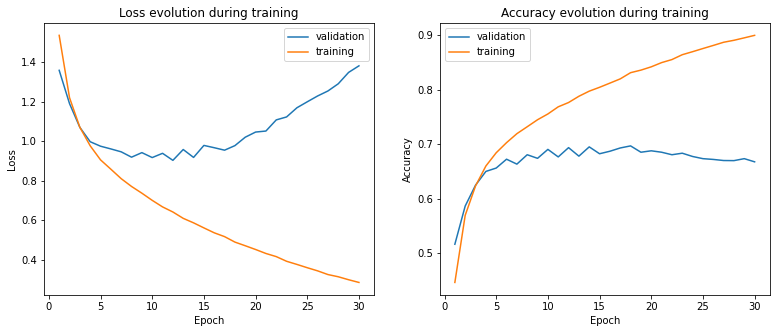

In [11]:
dropout_p = 0 #Probabilidad de apagar una neurona 
epochs = 30 # Inserte número de épocas
model = TwoBlockCNNModel(dropout_p)# Inserte modelo a entrenar
bool_data_augmentation=False

entrenamiento(dropout_p, epochs, model, bool_data_augmentation)

Using train transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/30
Iteration 117 - Batch 117/704 - Train loss: 2.099704481787601, Train acc: 0.227489406779661
Iteration 234 - Batch 234/704 - Train loss: 1.9937506650356536, Train acc: 0.26815159574468084
Iteration 351 - Batch 351/704 - Train loss: 1.917012203146111, Train acc: 0.29674183238636365
Iteration 468 - Batch 468/704 - Train loss: 1.8615152230903285, Train acc: 0.31633128997867804
Iteration 585 - Batch 585/704 - Train loss: 1.820627200115256, Train acc: 0.3328444965870307
Iteration 702 - Batch 702/704 - Train loss: 1.7805094747760388, Train acc: 0.34628378378378377
Val loss: 1.4554879665374756, Val acc: 0.4916
Epoch 2/30
Iteration 821 - Batch 117/704 - Train loss: 1.5731729915586568, Train acc: 0.4205508474576271
Iteration 938 - Batch 234/7

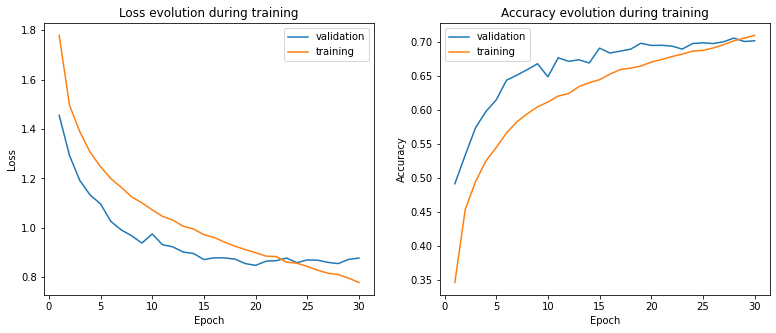

In [12]:
dropout_p = 0.5
epochs = 30 # Inserte número de épocas
model = TwoBlockCNNModel(dropout_p)# Inserte modelo a entrenar
bool_data_augmentation=False

entrenamiento(dropout_p, epochs, model, bool_data_augmentation)

## Experimento 2: Impacto del número de capas

Using train transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/30
Iteration 117 - Batch 117/704 - Train loss: 2.102649417974181, Train acc: 0.2341101694915254
Iteration 234 - Batch 234/704 - Train loss: 2.004632591693959, Train acc: 0.2710771276595745
Iteration 351 - Batch 351/704 - Train loss: 1.9340655414218253, Train acc: 0.2952325994318182
Iteration 468 - Batch 468/704 - Train loss: 1.886792075913598, Train acc: 0.31006796375266527
Iteration 585 - Batch 585/704 - Train loss: 1.8448820547439133, Train acc: 0.3242320819112628
Iteration 702 - Batch 702/704 - Train loss: 1.8118672791449817, Train acc: 0.33801564722617355
Val loss: 1.4832619428634644, Val acc: 0.4904
Epoch 2/30
Iteration 821 - Batch 117/704 - Train loss: 1.6079360842704773, Train acc: 0.4039989406779661
Iteration 938 - Batch 234/70

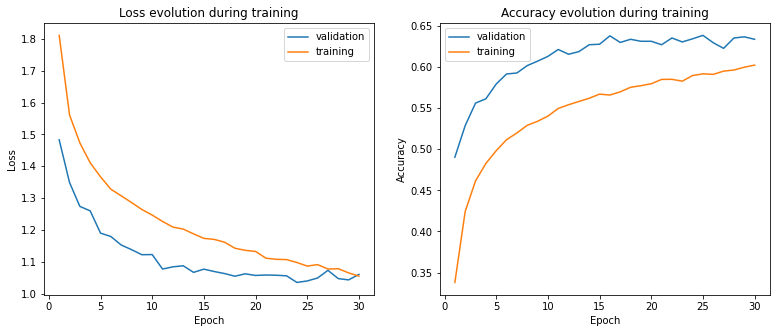

In [13]:
dropout_p = 0.5
epochs = 30 # Inserte número de épocas
model = SingleBlockCNNModel(dropout_p)# Inserte modelo a entrenar
bool_data_augmentation=False

entrenamiento(dropout_p, epochs, model, bool_data_augmentation)

Using train transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/30
Iteration 117 - Batch 117/704 - Train loss: 2.1604847726175342, Train acc: 0.188426906779661
Iteration 234 - Batch 234/704 - Train loss: 2.051528723696445, Train acc: 0.2288563829787234
Iteration 351 - Batch 351/704 - Train loss: 1.9797174469991163, Train acc: 0.2541725852272727
Iteration 468 - Batch 468/704 - Train loss: 1.9240745440729137, Train acc: 0.27631929637526653
Iteration 585 - Batch 585/704 - Train loss: 1.879480107042163, Train acc: 0.2953284982935154
Iteration 702 - Batch 702/704 - Train loss: 1.8428286064739416, Train acc: 0.3098995376955903
Val loss: 1.495832085609436, Val acc: 0.462
Epoch 2/30
Iteration 821 - Batch 117/704 - Train loss: 1.615618693626533, Train acc: 0.4058527542372881
Iteration 938 - Batch 234/704 - 

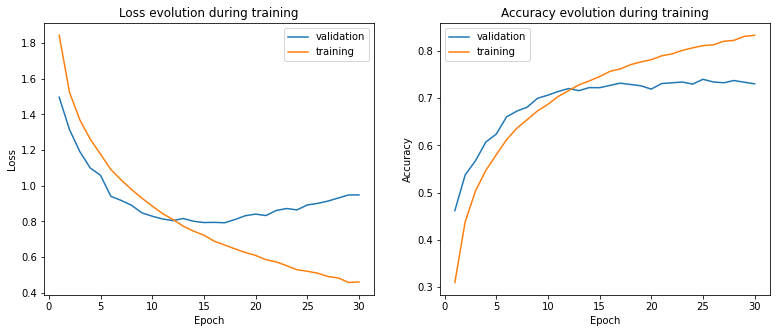

In [14]:
dropout_p = 0.5
epochs = 30 # Inserte número de épocas
model = CNNModel(dropout_p)# Inserte modelo a entrenar
bool_data_augmentation=False

entrenamiento(dropout_p, epochs, model, bool_data_augmentation)

## Experimento 3: Comparación con MLP

Using train transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/50
Iteration 117 - Batch 117/704 - Train loss: 2.0756200279219676, Train acc: 0.2751588983050847
Iteration 234 - Batch 234/704 - Train loss: 2.0052797469686956, Train acc: 0.30299202127659575
Iteration 351 - Batch 351/704 - Train loss: 1.9661488377235152, Train acc: 0.31578480113636365
Iteration 468 - Batch 468/704 - Train loss: 1.9360315629414149, Train acc: 0.3245935501066098
Iteration 585 - Batch 585/704 - Train loss: 1.914669732184947, Train acc: 0.329778156996587
Iteration 702 - Batch 702/704 - Train loss: 1.891994521424577, Train acc: 0.33572635135135137
Val loss: 1.6400560140609741, Val acc: 0.4284
Epoch 2/50
Iteration 821 - Batch 117/704 - Train loss: 1.7611750616865642, Train acc: 0.3805614406779661
Iteration 938 - Batch 234/7

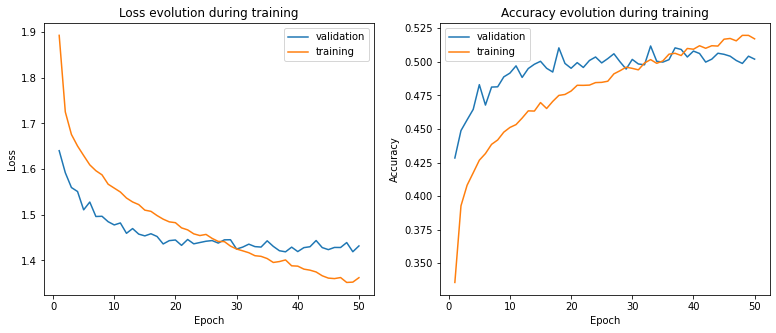

In [15]:
dropout_p = 0.5
epochs = 50 # Inserte número de épocas
model = MLPModel(dropout_p)# Inserte modelo a entrenar
bool_data_augmentation=False

entrenamiento(dropout_p, epochs, model, bool_data_augmentation)

## Experimento 4: Data Argumentation

Using train transform: Compose(
    Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
    RandomHorizontalFlip(p=0.5)
    Lambda()
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/30
Iteration 117 - Batch 117/704 - Train loss: 2.175936166512764, Train acc: 0.18604343220338984
Iteration 234 - Batch 234/704 - Train loss: 2.0634273843562347, Train acc: 0.2351063829787234
Iteration 351 - Batch 351/704 - Train loss: 1.9837655438618227, Train acc: 0.2658913352272727
Iteration 468 - Batch 468/704 - Train loss: 1.9192169876749328, Train acc: 0.28874600213219614
Iteration 585 - Batch 585/704 - Train loss: 1.8707827295052721, Train acc: 0.30823378839590443
Iteration 702 - Batch 702/704 - Train loss: 1.8297121463764783, Train acc: 0.3242576458036984
Val loss: 1.481080412864685, Val acc: 0.4824
Epoch 2/30
Iteration 821 - Batch 117/704 - Train loss: 1.58232682539244

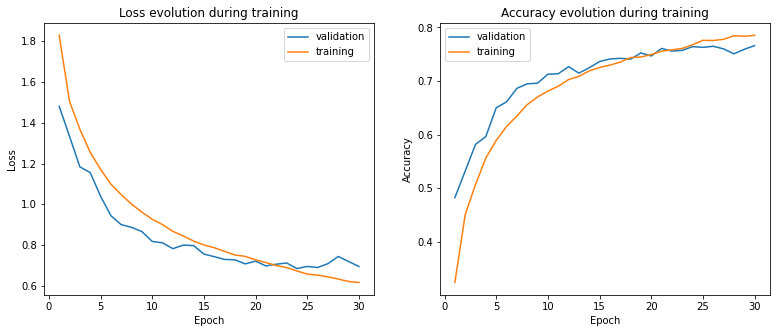

In [76]:
dropout_p = 0.5
epochs = 30 # Inserte número de épocas
model1 = CNNModel(dropout_p)# Inserte modelo a entrenar
bool_data_augmentation=True

entrenamiento(dropout_p, epochs, model1, bool_data_augmentation)

## Experimento 5: Removiendo capas fully conected

In [50]:
class CNNModel2(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1
            nn.Conv2d(3, 16, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 2
            nn.Conv2d(16, 32, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 3
            nn.Conv2d(32, 64, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 10, kernel_size=1, padding="same"),
            nn.AvgPool2d(kernel_size=4)
        )


        self.net = nn.Sequential(
            self.conv_blocks, nn.Flatten()
        )

    def forward(self, x):
        return self.net(x)

In [51]:
model = CNNModel2(dropout_p=0.5)

print(model(train_cifar10[0][0].unsqueeze(0)).shape)

torch.Size([1, 10])


Using train transform: Compose(
    Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
    RandomHorizontalFlip(p=0.5)
    Lambda()
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/30
Iteration 117 - Batch 117/704 - Train loss: 2.097689930665291, Train acc: 0.21583686440677965
Iteration 234 - Batch 234/704 - Train loss: 1.9674513994379246, Train acc: 0.26861702127659576
Iteration 351 - Batch 351/704 - Train loss: 1.8859893086959014, Train acc: 0.3004705255681818
Iteration 468 - Batch 468/704 - Train loss: 1.8292079439549558, Train acc: 0.32119536247334757
Iteration 585 - Batch 585/704 - Train loss: 1.7863396703179786, Train acc: 0.33921715017064846
Iteration 702 - Batch 702/704 - Train loss: 1.7485705190159349, Train acc: 0.35421852773826457
Val loss: 1.5121382474899292, Val acc: 0.4558
Epoch 2/30
Iteration 821 - Batch 117/704 - Train loss: 1.50280034239

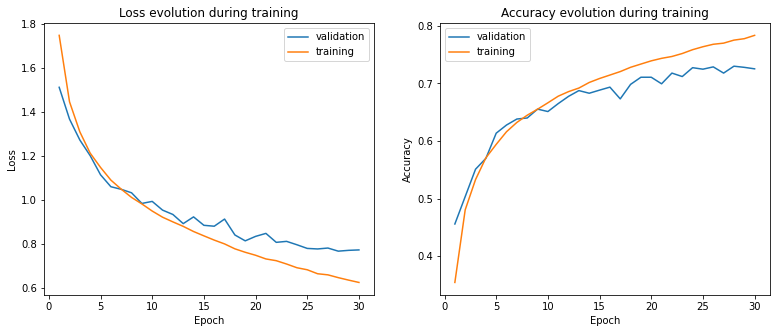

In [52]:
dropout_p = 0.5
epochs = 30 # Inserte número de épocas
model2 = CNNModel2(dropout_p)# Inserte modelo a entrenar
bool_data_augmentation=True

entrenamiento(dropout_p, epochs, model2, bool_data_augmentation)

In [75]:
#Información del modelo sin capas fully conected
parametros_totales=sum(p.numel() for p in model2.parameters())
memoria=parametros_totales*4 #Memoria en bytes
print('Cantidad de parametros', parametros_totales)
print('Memoria en bytes:', memoria)

Cantidad de parametros 65962
Memoria en bytes: 263848


In [77]:
#Información del modelo con capas fully conected
parametros_totales=sum(p.numel() for p in model1.parameters())
memoria=parametros_totales*4 #Memoria en bytes
print('Cantidad de parametros', parametros_totales)
print('Memoria en bytes:', memoria)

Cantidad de parametros 117072
Memoria en bytes: 468288
